# Install statements

In [23]:
! pip install fast_ml --quiet
! pip install opencv-python
! pip install pandas
! pip install --upgrade pip
! pip install seaborn
! pip install tensorflow
! pip install tqdm

# Initial setup (Always run)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import seaborn as sns
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Flatten
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from fast_ml.model_development import train_valid_test_split
import pathlib

2.17.0


# Preprocessing 

In [64]:
# Directory paths
tsinghua_image_path = os.getcwd()+'/dog_classes'

# Step 1: Load image file paths and labels
def load_image_paths_and_labels(data_dir):

    #classes = os.listdir(data_dir)
    classes = os.listdir(data_dir)[:2]  # Only take the first 3 classes

    image_paths = []
    labels = []

    for label, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(label) #TODO: Change this to be the class name (Dog breed)

    return image_paths, labels

# Load the paths and labels
image_paths, labels = load_image_paths_and_labels(tsinghua_image_path)
print(image_paths)
# Step 2: Create a parsing function to load and preprocess the images
def parse_image(image_path, label, target_size=(224, 224)):
    # Load and decode the image
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)  # Convert to array (height, width, channels)

    # Normalize to [0, 1]
    image /= 255.0 # TODO: Do we need to do this?

    return image, label

# Create a function to calculate the mean over the entire dataset
def compute_dataset_mean(image_paths):
    total_sum = np.zeros(3)  # Assuming RGB images
    total_count = 0

    for img_path in image_paths:
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1] TODO: IS normalising necesary?
        total_sum += np.mean(img_array, axis=(0, 1))  # Mean over width, height for each channel
        total_count += 1

    dataset_mean = total_sum / total_count
    return dataset_mean

# Step 3: Compute the feature-wise mean (over the whole dataset)
dataset_mean = compute_dataset_mean(image_paths)
print("Dataset Mean: ", dataset_mean)

# Step 4: Create a function to apply featurewise centering
def zero_centering(image, dataset_mean):
    return image - dataset_mean

# Step 5: Create the tf.data.Dataset pipeline
def load_dataset(image_paths, labels, dataset_mean):
    # Convert the image paths and labels to a tf.data Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Parse and preprocess each image
    dataset = dataset.map(
        lambda img_path, label: tf.py_function(func=lambda x, y: parse_image(x.numpy(), y),
                                               inp=[img_path, label],
                                               Tout=[tf.float32, tf.int32])
    )

    # Apply feature-wise centering (subtract the dataset mean)
    dataset = dataset.map(
        lambda img, label: (zero_centering(img, dataset_mean), label)
    )

    return dataset

# Step 6: Load the dataset using the dataloader
batch_size = 32  # Adjust based on memory constraints
train_dataset = load_dataset(image_paths, labels, dataset_mean)
# Now the dataset is ready for model training


['/Users/helenacooper/Desktop/Uni/7. semester/Deep Learning/Project/Dog-Breed-Classifier/dog_classes/201-n000024-schipperke/n110442.jpg', '/Users/helenacooper/Desktop/Uni/7. semester/Deep Learning/Project/Dog-Breed-Classifier/dog_classes/201-n000024-schipperke/n110456.jpg', '/Users/helenacooper/Desktop/Uni/7. semester/Deep Learning/Project/Dog-Breed-Classifier/dog_classes/201-n000024-schipperke/n110481.jpg', '/Users/helenacooper/Desktop/Uni/7. semester/Deep Learning/Project/Dog-Breed-Classifier/dog_classes/201-n000024-schipperke/n110495.jpg', '/Users/helenacooper/Desktop/Uni/7. semester/Deep Learning/Project/Dog-Breed-Classifier/dog_classes/201-n000024-schipperke/n110536.jpg', '/Users/helenacooper/Desktop/Uni/7. semester/Deep Learning/Project/Dog-Breed-Classifier/dog_classes/201-n000024-schipperke/n110522.jpg', '/Users/helenacooper/Desktop/Uni/7. semester/Deep Learning/Project/Dog-Breed-Classifier/dog_classes/201-n000024-schipperke/n110523.jpg', '/Users/helenacooper/Desktop/Uni/7. seme

# Visualize data

In [8]:
tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

print('Number of dog breeds: ', len(classes))

#Make empty array to save info about dog breeds and their frequencies
class_names_and_frequencies = []

#Loop through all classes
for class_name in classes:
    class_path = os.path.join(tsinghua_image_path, class_name)
    
    if class_name.startswith('.'):
        print(f"Skipping hidden file: {class_name}")
        continue
    
    dog_name = class_name.split('-')[2] #We only want after the second occurence of "-" in the directory name
    
    
    dog_frequency = len(os.listdir(class_path))
    class_names_and_frequencies.append((dog_name, dog_frequency))

#Get the dataframe
df = pd.DataFrame(class_names_and_frequencies, columns = ['Breeds', 'Frequency'])
print('Total number of images :', df['Frequency'].sum())

Number of dog breeds:  131
Skipping hidden file: .DS_Store
Total number of images : 70432


In [24]:
#Check if it looks alright
df.head()

,Breeds,Frequency
0,schipperke,201
1,Australian_Shepherd,245
2,Shetland_sheepdog,274
3,black_and_tan_coonhound,225
4,Gordon_setter,228


<AxesSubplot: title={'center': 'Frequency of dog breeds in descending order'}, xlabel='Frequency', ylabel='Breeds'>

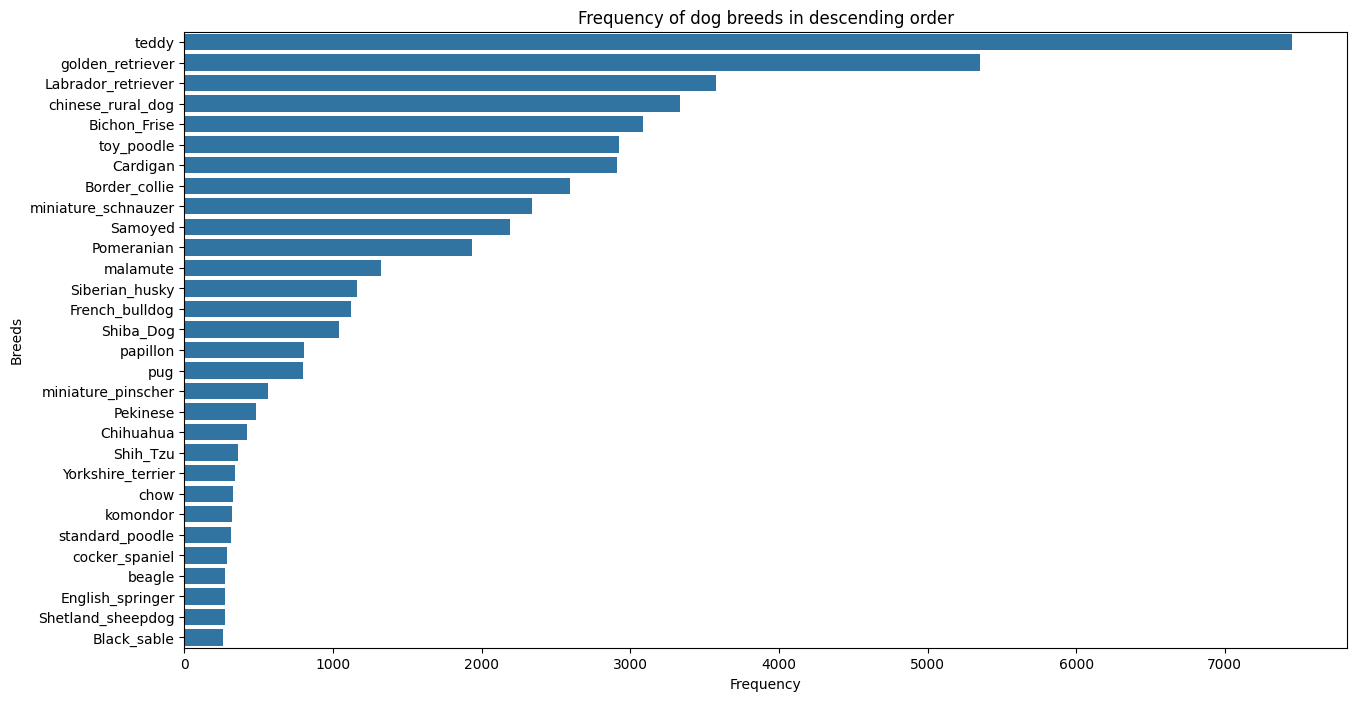

In [9]:
#Plot the distribution of dog breeds
plt.figure(figsize=(15,8))
plt.title('Frequency of dog breeds in descending order')
sns.barplot(x = 'Frequency', y = 'Breeds', data = df.sort_values('Frequency', ascending = False).head(30))

# Preprocessing

In [82]:
#Array containing all data
dogs = []

tsinghua_image_path = os.getcwd()+'/dog_classes'
classes = os.listdir(tsinghua_image_path)

classes = classes[:26]
print(len(classes))

for dog_breed in classes:
    if dog_breed.startswith('.'):
        print(f"Skipping hidden file: {dog_breed}")
        continue
    dog_breed_path = os.path.join(tsinghua_image_path, dog_breed)
    for image_id in os.listdir(dog_breed_path):
        path = os.path.join(dog_breed_path, image_id)
        label = dog_breed.split('-')[2]
        dogs.append((path, label))

df = pd.DataFrame(dogs, columns = ['Image path', 'Label'])
print('Shape of dataframe :', df.shape)

df.head()

26
Skipping hidden file: .DS_Store
Shape of dataframe : (11265, 2)


,Image path,Label
0,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
1,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
2,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
3,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke
4,/Users/helenacooper/Desktop/Uni/7. semester/De...,schipperke


In [39]:
# Compute the dataset mean
data_mean = compute_dataset_mean(df['Image path'].tolist())
print("Dataset Mean: ", data_mean)

df_with_images = load_images_into_dataframe(df, data_mean)

# Now the DataFrame contains paths, labels, and processed images
df.head(5)

Dataset Mean:  [0.49053261 0.47621457 0.41360671]


KeyboardInterrupt: 

# Train, validation, and test split

Now we can split the Dataframe, `df`, that contains all our data into training, validation and test sets

In [5]:
# train, test, validation split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_with_images,
                                                                            target = 'Label',
                                                                            train_size=0.6,
                                                                            valid_size=0.2,
                                                                            test_size=0.2)

# Reset the indices of the different sets
for data in [X_train, y_train, X_valid, y_valid, X_test, y_test]:
    data.reset_index(drop=True, inplace=True)

In [6]:
# Print the dataset sizes
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)


(703, 2) (703,)
(235, 2) (235,)
(235, 2) (235,)


In [ ]:
X_train.head(10)

# Model training

In [23]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from keras.applications.mobilenet import preprocess_input
import math



#### Get the encoder

In [3]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))
#conv_base.summary()

#### Specify the whole model

In [5]:
# Number of classes
N=2

# Add new top layer
x = conv_base.output #the output of base model to go into top layers
x = GlobalAveragePooling2D()(x) #notsure
x = Dense(1024,activation='relu')(x) #dense layer, dafuq
#x = Dropout(0.5)(x)  # Dropout added here
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation to make class predictions

# Specify model, combination of encoder and customised top layer
model = Model(inputs=conv_base.input, outputs=preds)

#### We will only be training the new dense layers that we added. Disable training for all previous layers and enable for new layers:


In [6]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


#### Prepare ImageDataGenerator with data from dataframe
Note: preprocessing is model specific

In [20]:
# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

dog_class_directory = os.getcwd()+'/dog_classes'

selected_classes = ['5355-n000126-golden_retriever', '7449-n000128-teddy']

train_generator = datagen.flow_from_directory(
    directory = dog_class_directory,
    classes=selected_classes,
    target_size=(224, 224),         # Resize images to this size
    batch_size=8,
    class_mode='categorical',       # Set to 'categorical' for multi-class labels
    subset='training',              # Define subset as 'training'
    shuffle=False
)

validation_generator = datagen.flow_from_directory(
    directory = dog_class_directory,
    classes=selected_classes,
    target_size=(224, 224),         # Resize images to this size
    batch_size=8,
    class_mode='categorical',       # Set to 'categorical' for multi-class labels
    subset='validation',              # Define subset as 'training'
    shuffle=False
)

Found 10244 images belonging to 2 classes.
Found 2560 images belonging to 2 classes.


Test uden generator

In [71]:
dog_class_directory = os.getcwd()+'/dog_classes'

selected_classes = ['5355-n000126-golden_retriever', '7449-n000128-teddy']

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "training",
    validation_split =0.2,
    shuffle=True,
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=dog_class_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=selected_classes,   # Specify the classes to load
    image_size=(224, 224),          # Resize to the target size
    batch_size=8,
    subset = "validation",
    validation_split =0.2,
    shuffle=True,
    seed=123
)


Found 12804 files belonging to 2 classes.
Using 10244 files for training.
Found 12804 files belonging to 2 classes.
Using 2560 files for validation.


In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
history = model.fit(train_dataset, 
          validation_data=val_dataset, 
          epochs=10)

Epoch 1/10


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


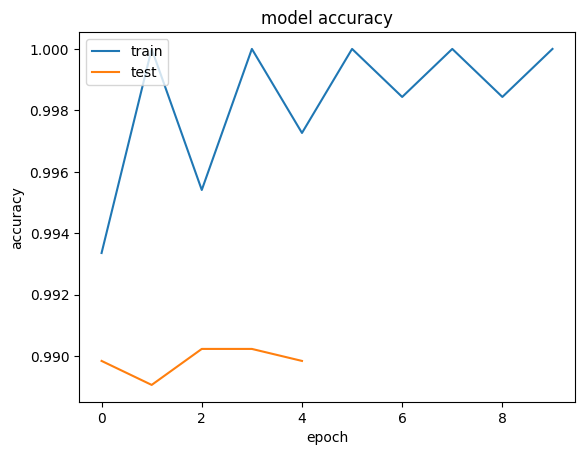

In [75]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### We are now ready to start training the model using


In [60]:
# Set up optimizer
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100,
    decay_rate=1e-6)
#sgd_optimizer = optimizers.SGD(learning_rate=lr_schedule,momentum=0.9, nesterov=True)

sgd_optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit(train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
   7/1280 ━━━━━━━━━━━━━━━━━━━━ 1:28 69ms/step - accuracy: 0.9909 - loss: 0.0215

KeyboardInterrupt: 

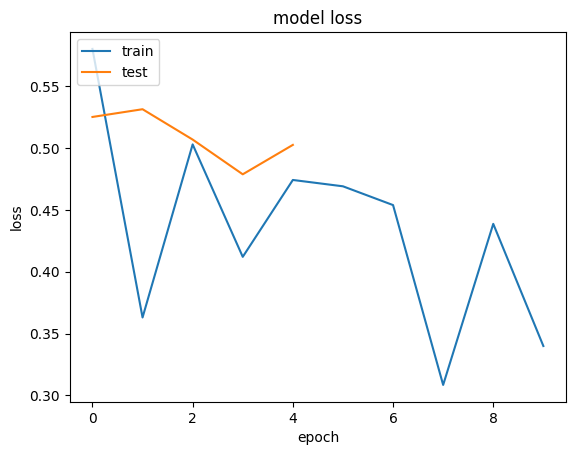

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()